In [ ]:
# Ispirato dal video https://www.youtube.com/watch?v=6clmthGECvc&t=0s

# Metodo 1

## Importazione librerie

In [4]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

## Download dati

In [2]:
# Inizializza l'exchange
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe desiderato
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Calcola la data di inizio (ad esempio, 365 giorni fa)
since = exchange.parse8601((datetime.now() - timedelta(days=365)).strftime('%Y-%m-%dT%H:%M:%S'))

# Scarica i dati storici
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-11-26,37780.67,37814.63,37150.00,37447.43,21264.53723
2023-11-27,37447.42,37569.23,36707.00,37242.70,30001.07376
2023-11-28,37242.70,38377.00,36868.41,37818.87,37544.46667
2023-11-29,37818.88,38450.00,37570.00,37854.64,32994.19107
2023-11-30,37854.65,38145.85,37500.00,37723.96,24740.29147


## Analisi ciclica

Frequenze dominanti (cicli/giorno): [0.00273973 0.00821918 0.00547945]
Periodi dominanti (giorni): [365.         121.66666667 182.5       ]


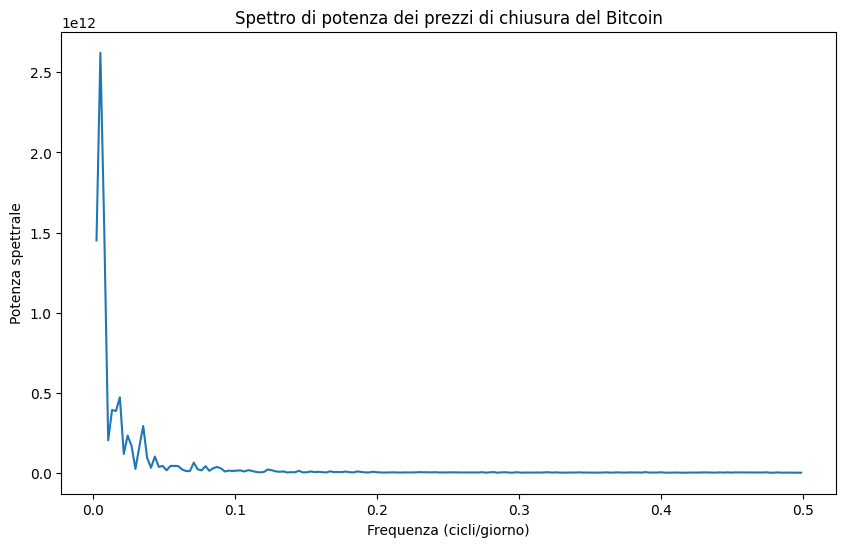

In [5]:
# Estrai i prezzi di chiusura
close_prices = df['close'].values

# Calcola la media e sottraila dai prezzi per rimuovere la componente DC
close_prices_detrended = close_prices - np.mean(close_prices)

# Applica la Trasformata di Fourier
fft_result = np.fft.fft(close_prices_detrended)
fft_freq = np.fft.fftfreq(len(fft_result))

# Calcola la potenza spettrale
power_spectrum = np.abs(fft_result)**2

# Filtra le frequenze positive
positive_freqs = fft_freq > 0
freqs = fft_freq[positive_freqs]
power = power_spectrum[positive_freqs]

# Identifica le frequenze dominanti
dominant_freqs = freqs[np.argsort(power)[-3:]]  # Le 3 frequenze con potenza maggiore
dominant_periods = 1 / dominant_freqs

print("Frequenze dominanti (cicli/giorno):", dominant_freqs)
print("Periodi dominanti (giorni):", dominant_periods)

# Visualizza lo spettro di potenza
plt.figure(figsize=(10, 6))
plt.plot(freqs, power)
plt.xlabel('Frequenza (cicli/giorno)')
plt.ylabel('Potenza spettrale')
plt.title('Spettro di potenza dei prezzi di chiusura del Bitcoin')
plt.show()

## Generazione dei segnali di trading

In [6]:
# Seleziona la frequenza dominante principale
dominant_freq = dominant_freqs[np.argmax(power)]

# Calcola il periodo dominante
dominant_period = int(1 / dominant_freq)

# Crea un indicatore sinusoidale basato sul periodo dominante
t = np.arange(len(close_prices))
sinusoid = np.sin(2 * np.pi * dominant_freq * t)

# Normalizza l'indicatore
sinusoid_normalized = (sinusoid - np.min(sinusoid)) / (np.max(sinusoid) - np.min(sinusoid))

# Aggiungi l'indicatore al DataFrame
df['sinusoid_indicator'] = sinusoid_normalized

# Genera segnali di acquisto e vendita
df['signal'] = 0
df.loc[df['sinusoid_indicator'] < 0.2, 'signal'] = 1  # Segnale di acquisto
df.loc[df['sinusoid_indicator'] > 0.8, 'signal'] = -1  # Segnale di vendita

print(df[['close', 'sinusoid_indicator', 'signal']].tail())

               close  sinusoid_indicator  signal
timestamp                                       
2024-11-20  94286.56            0.372322       0
2024-11-21  98317.12            0.397447       0
2024-11-22  98892.00            0.422845       0
2024-11-23  97672.40            0.448449       0
2024-11-24  95963.13            0.474190       0


## Implementazione del sistema di trading

In [ ]:
# def execute_trade(signal, symbol, amount):
#     if signal == 1:
#         # Esegui ordine di acquisto
#         order = exchange.create_market_buy_order(symbol, amount)
#         print(f"Acquistato {amount} di {symbol}")
#     elif signal == -1:
#         pass

# Metodo 2

## Importazione librerie

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

## Download dati

In [8]:
# Inizializza l'exchange Binance
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Definisci il numero di candele da scaricare
limit = 1000

# Scarica i dati OHLCV
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Converti il timestamp in formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Imposta il timestamp come indice
df.set_index('timestamp', inplace=True)

## Analisi ciclica

In [9]:
# Calcola la Trasformata di Fourier
fft = np.fft.fft(df['close'])
frequencies = np.fft.fftfreq(len(fft))

# Calcola la potenza spettrale
power = np.abs(fft)**2

# Filtra le frequenze positive
positive_frequencies = frequencies[frequencies > 0]
positive_power = power[frequencies > 0]

# Identifica la frequenza dominante
dominant_frequency = positive_frequencies[np.argmax(positive_power)]
dominant_period = 1 / dominant_frequency

print(f'Periodo dominante: {dominant_period} giorni')

Periodo dominante: 1000.0 giorni


## Identificazione dei minimi e massimi locali

In [10]:
# Definisci il filtro passa-basso
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Applica il filtro
cutoff = 1 / dominant_period  # Frequenza di taglio
fs = 1  # Frequenza di campionamento (1 giorno)
order = 2

b, a = butter_lowpass(cutoff, fs, order)
df['filtered'] = filtfilt(b, a, df['close'])

# Identifica minimi e massimi locali
df['min_local'] = (df['filtered'].shift(1) > df['filtered']) & (df['filtered'].shift(-1) > df['filtered'])
df['max_local'] = (df['filtered'].shift(1) < df['filtered']) & (df['filtered'].shift(-1) < df['filtered'])

## Generazione dei segnali di trading

In [11]:
df['signal'] = 0
df.loc[df['min_local'], 'signal'] = 1  # Segnale di acquisto
df.loc[df['max_local'], 'signal'] = -1  # Segnale di vendita

## Visualizzazione dei risultati

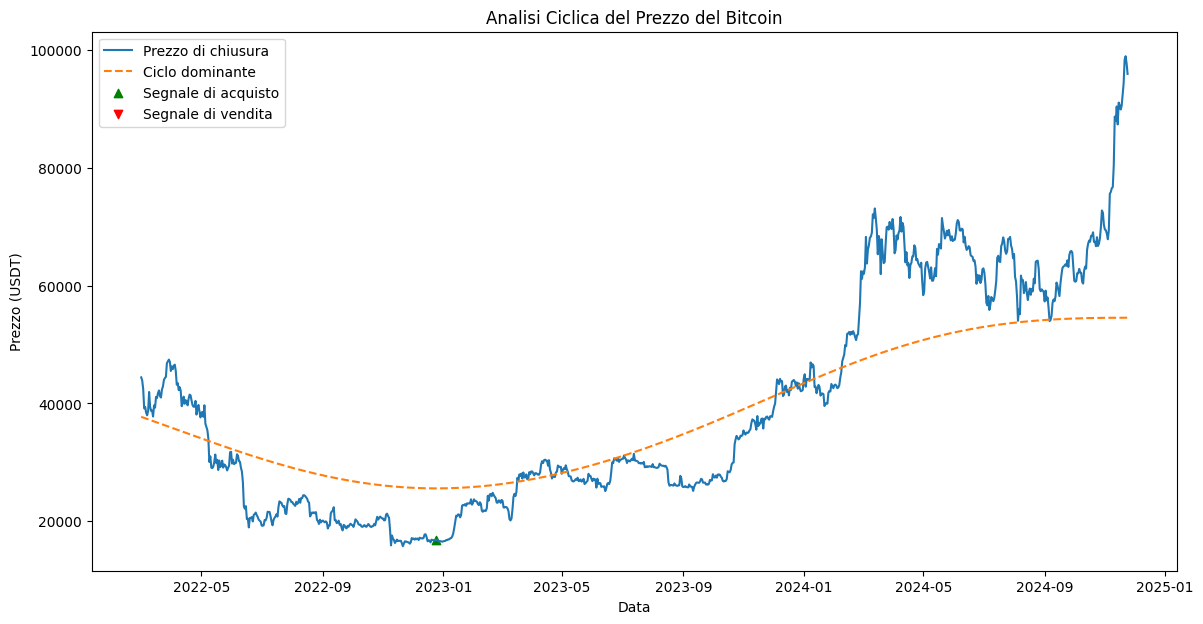

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Prezzo di chiusura')
plt.plot(df.index, df['filtered'], label='Ciclo dominante', linestyle='--')
plt.scatter(df.index[df['signal'] == 1], df['close'][df['signal'] == 1], marker='^', color='g', label='Segnale di acquisto')
plt.scatter(df.index[df['signal'] == -1], df['close'][df['signal'] == -1], marker='v', color='r', label='Segnale di vendita')
plt.legend()
plt.title('Analisi Ciclica del Prezzo del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo (USDT)')
plt.show()